<h1><center>Global stuff</center></h1>

In [13]:
# Eases updating libs
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Imports
# from libraries.project_functions import *
from libraries.global_functions import *
import numpy
import scipy.signal
import pygsp
import ipywidgets

In [15]:
# Random seed
numpy.random.seed(0)

In [16]:
# Useful constants
OUTPUT_DIR = "output/first_tests/"

<h1><center>Recreation of https://arxiv.org/pdf/1307.5708.pdf</center></h1>

<h2>Temporal version</h2>

In [17]:
# Constants
GRAPH_ORDER = 100
KERNEL_SCALE = 300

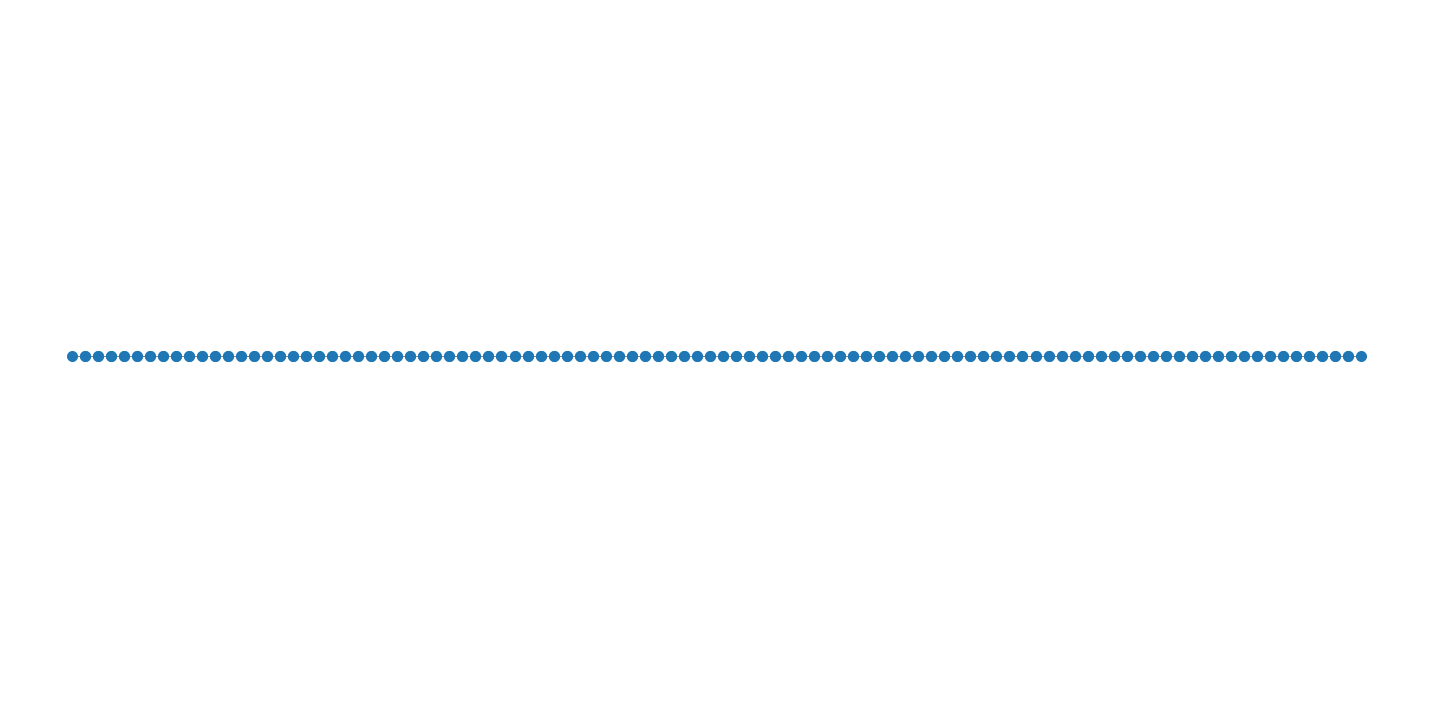

In [18]:
# Let's work on a path graph
graph = create_path_graph(GRAPH_ORDER)

# Plot
plot_graph(graph)

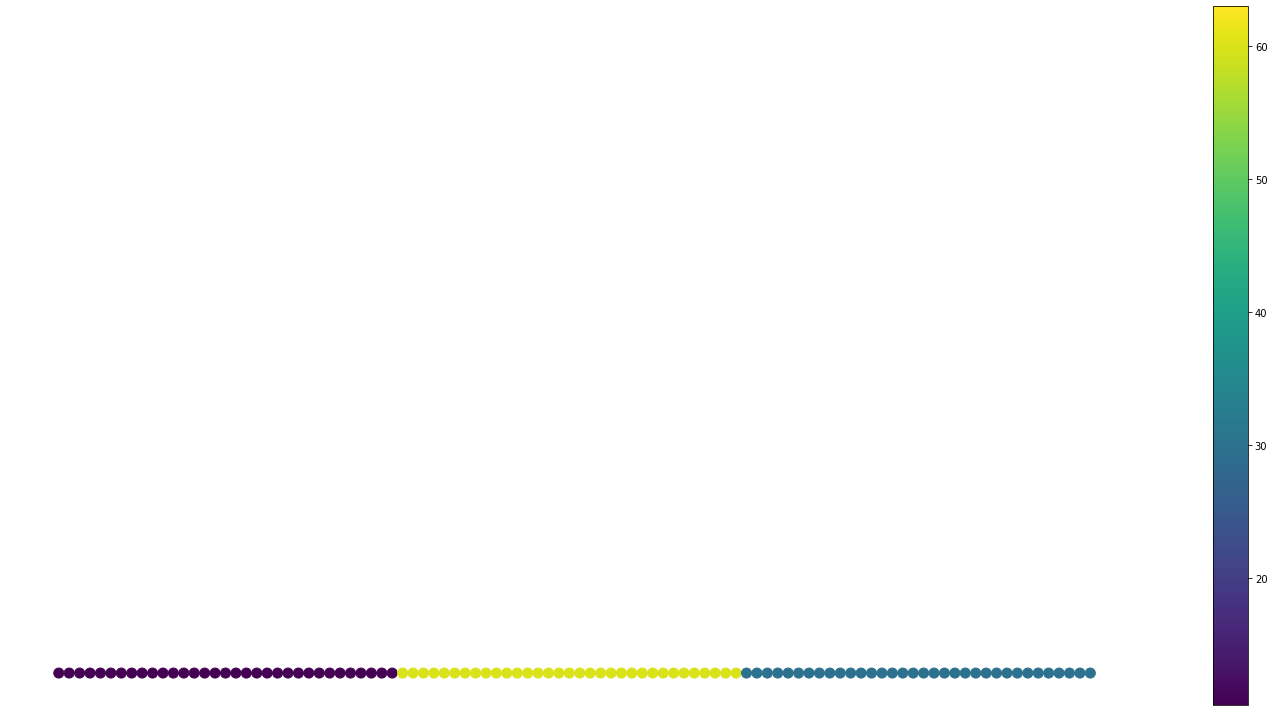

In [24]:
# We create 3 groups of vertices
groups = numpy.array([10] * (graph.N//3) +
                     [60] * (graph.N//3) +
                     [30] * (graph.N-2*graph.N//3))

# Plot
plot_graph(graph, groups)

[[-0.1        -0.14140391 -0.14135157 ... -0.00666186 -0.00444215
   0.00222135]
 [-0.1        -0.14126436 -0.14079372 ...  0.01992644  0.01330893
  -0.00666186]
 [-0.1        -0.1409854  -0.13968022 ... -0.03301416 -0.02212317
   0.01109579]
 ...
 [-0.1         0.1409854  -0.13968022 ...  0.03301416 -0.02212317
  -0.01109579]
 [-0.1         0.14126436 -0.14079372 ... -0.01992644  0.01330893
   0.00666186]
 [-0.1         0.14140391 -0.14135157 ...  0.00666186 -0.00444215
  -0.00222135]]


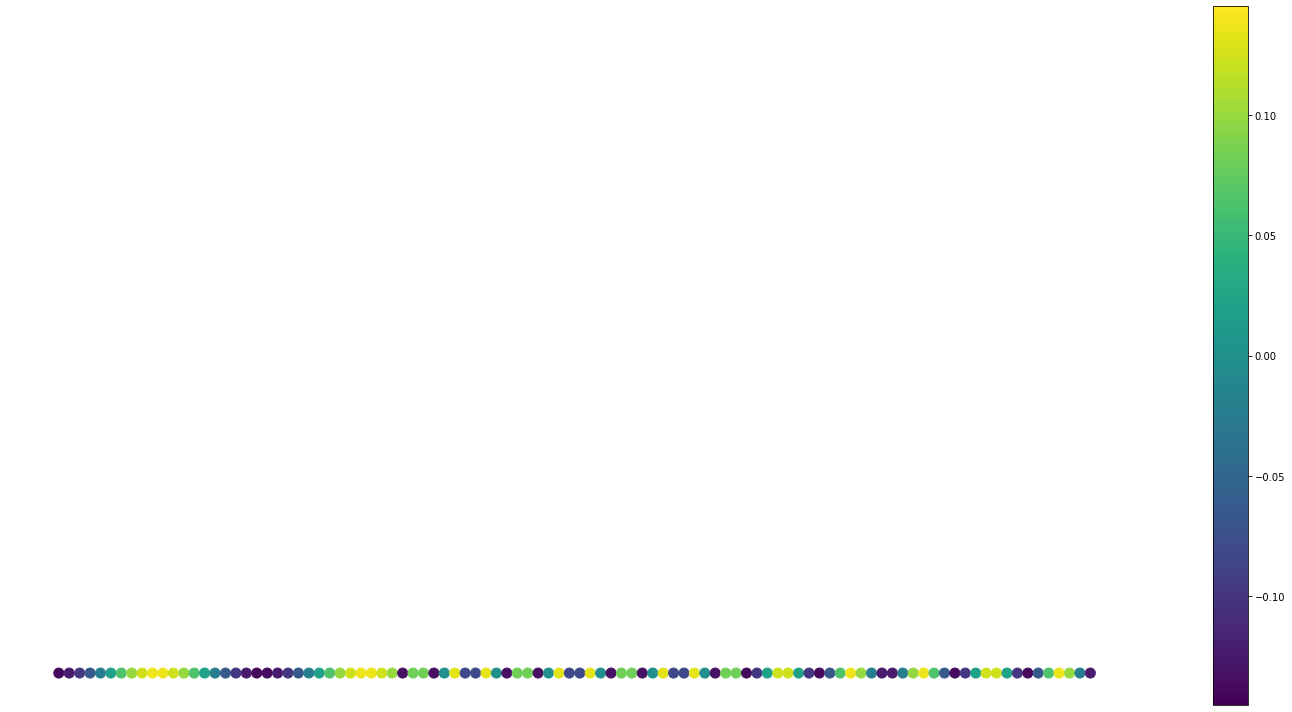

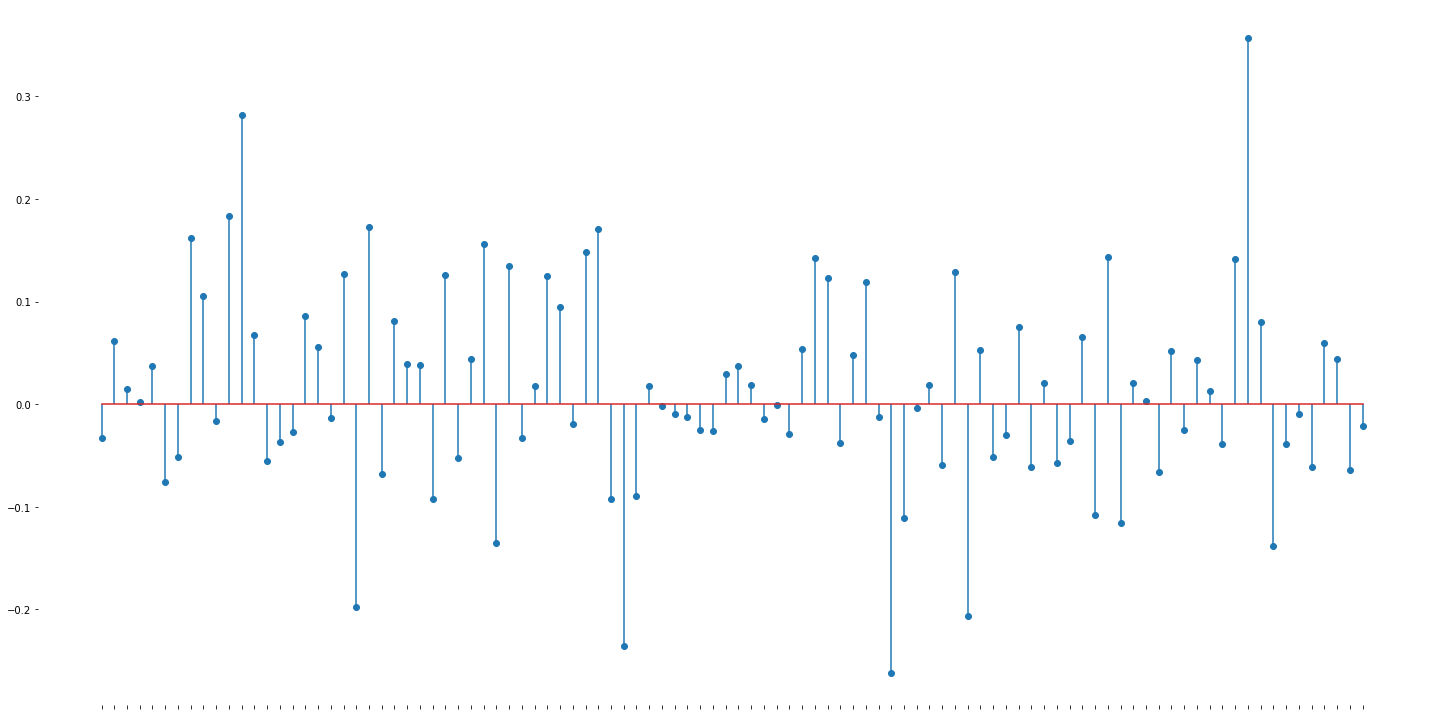

In [32]:
# Signal to analyze is a mix between some frequencies
x = numpy.array([graph.U[i, int(groups[i])] for i in range(graph.N)])
x /= numpy.linalg.norm(x)

# Plot
plot_graph(graph, x)
plot_stem(graph.igft(x))

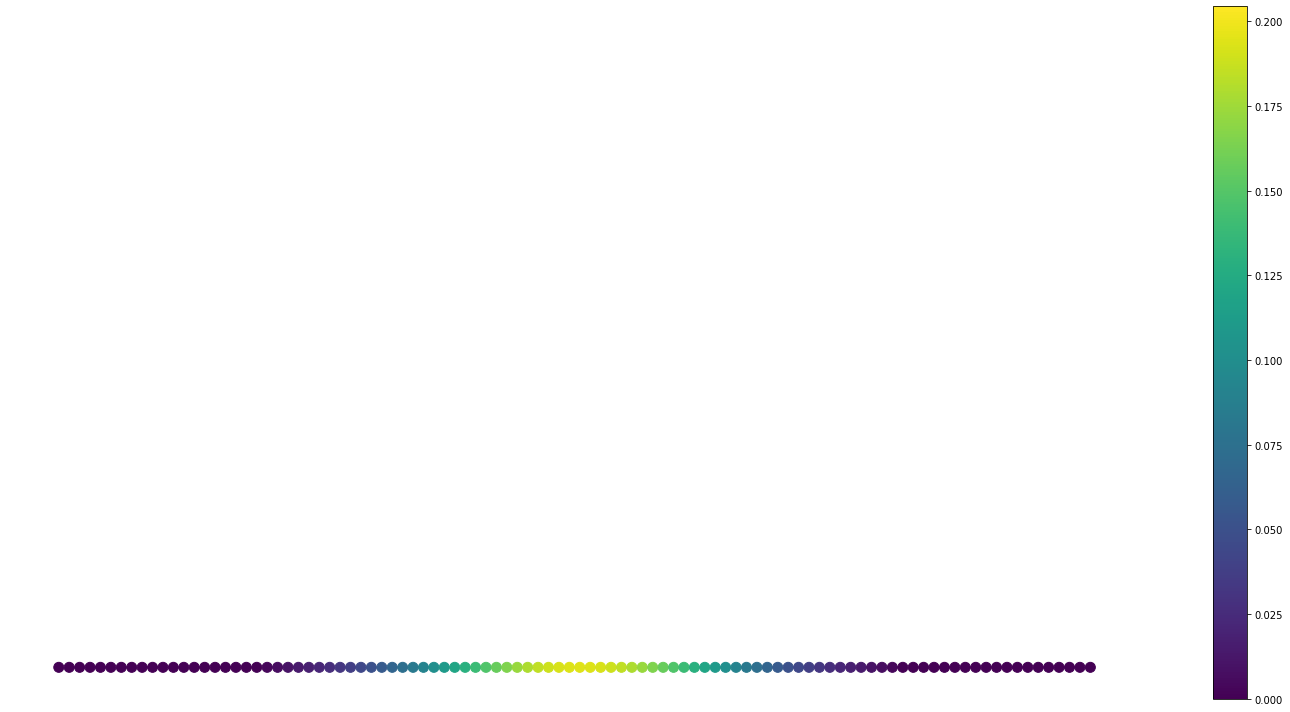

In [9]:
# We use a window defined by a heat kernel
# Needs to be instanciated on a particular vertex to be the object we want
window_kernel = create_heat_kernel(graph, KERNEL_SCALE)
localized_kernel = window_kernel.localize(int(graph.N/2))

# Plot
plot_graph(graph, localized_kernel)

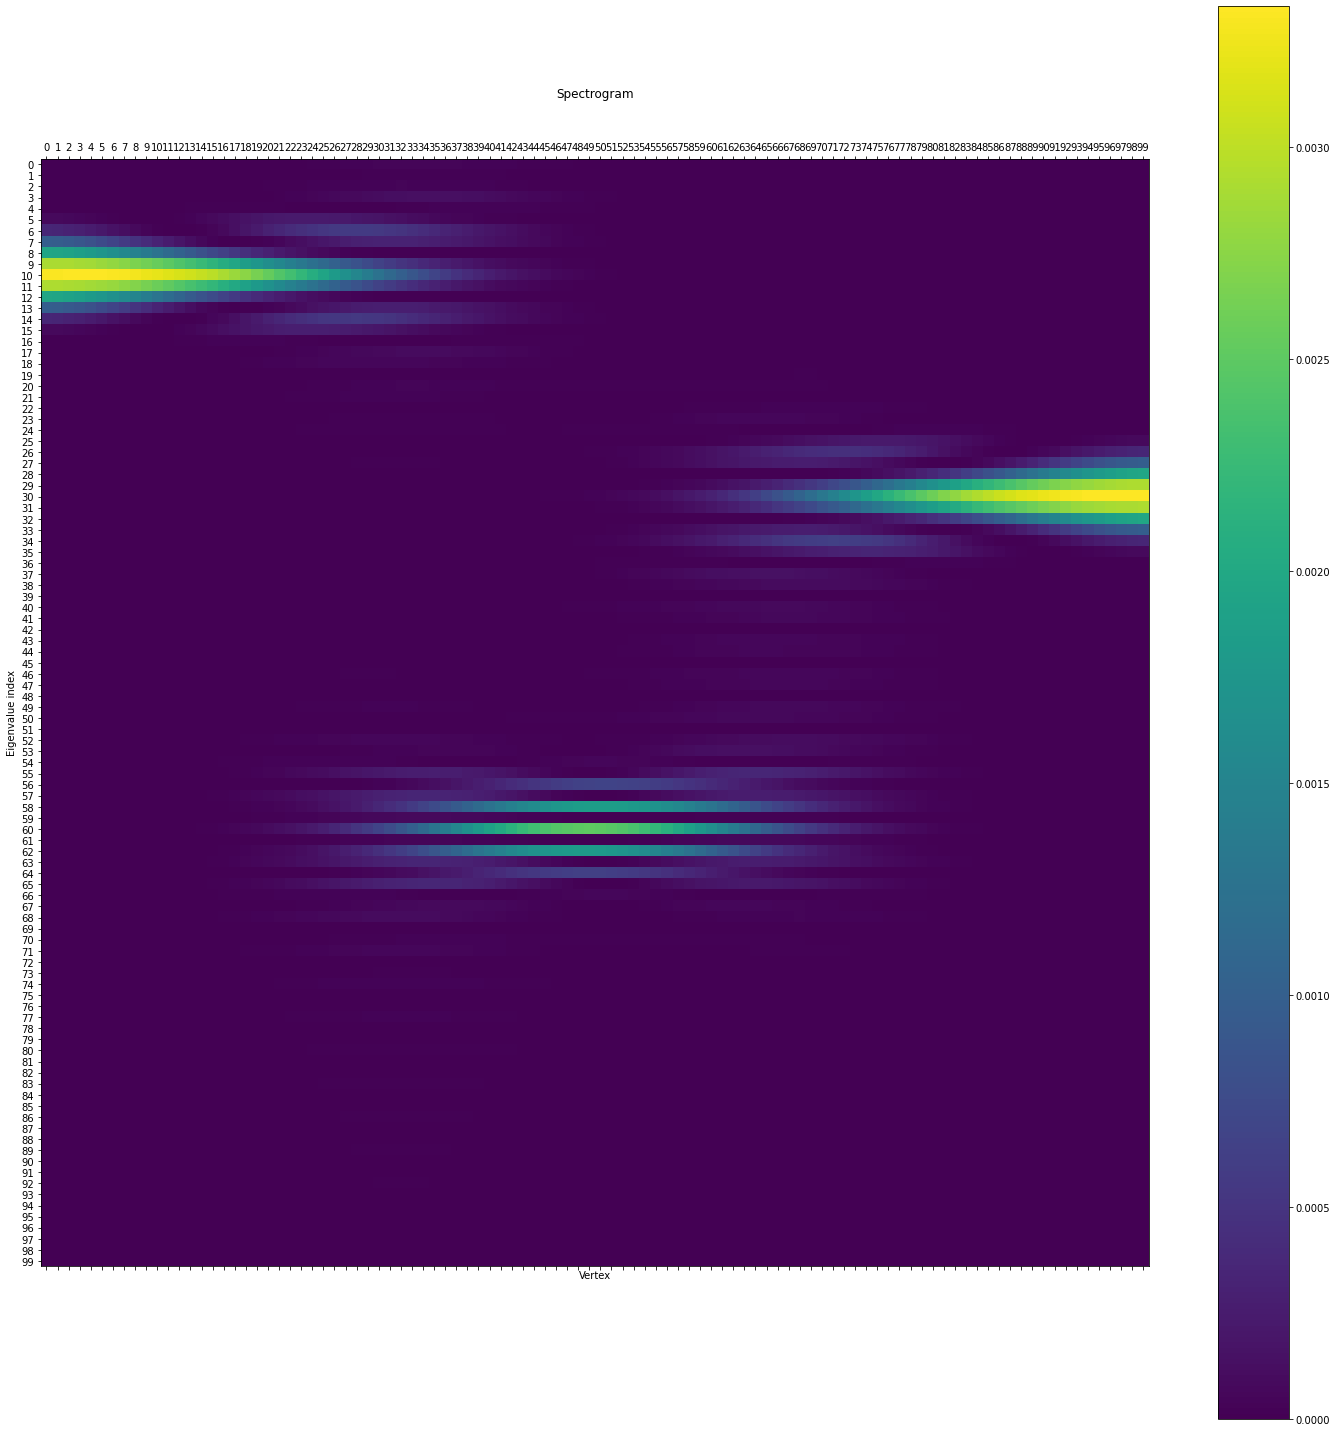

In [10]:
# Graph spectrogram of the signal
spectrogram = compute_graph_spectrogram(graph, x, window_kernel)

# Plot
plot_matrix(spectrogram,
            cols_title="Vertex",
            cols_labels=range(graph.N),
            rows_title="Eigenvalue index",
            rows_labels=range(graph.N),
            title="Spectrogram",
            colorbar=True)

<h2>Spatial version</h2>

In [9]:
# Constants
GRAPH_ORDER = 100
KERNEL_SCALE = 10

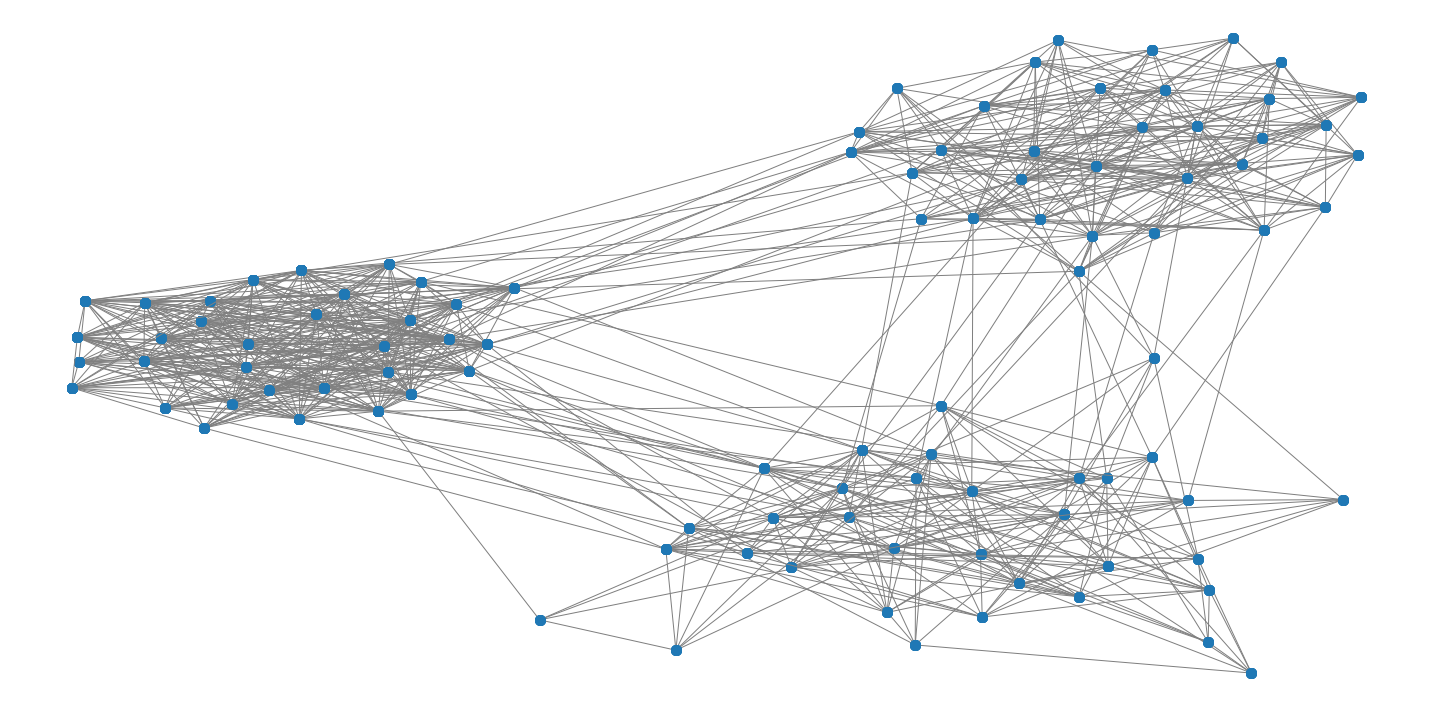

In [10]:
# Let's work on a SBM of 3 blocks
groups = numpy.array([0] * (GRAPH_ORDER//3) + [1] * (GRAPH_ORDER//3) + [2] * (GRAPH_ORDER-2*GRAPH_ORDER//3))
graph = pygsp.graphs.StochasticBlockModel(GRAPH_ORDER, k=3, z=groups, p=[0.4, 0.6, 0.3], q=0.02)
graph.set_coordinates(kind="spring", seed=numpy.random.randint(2**32))
graph.compute_fourier_basis()

# Plot
plot_graph(graph)

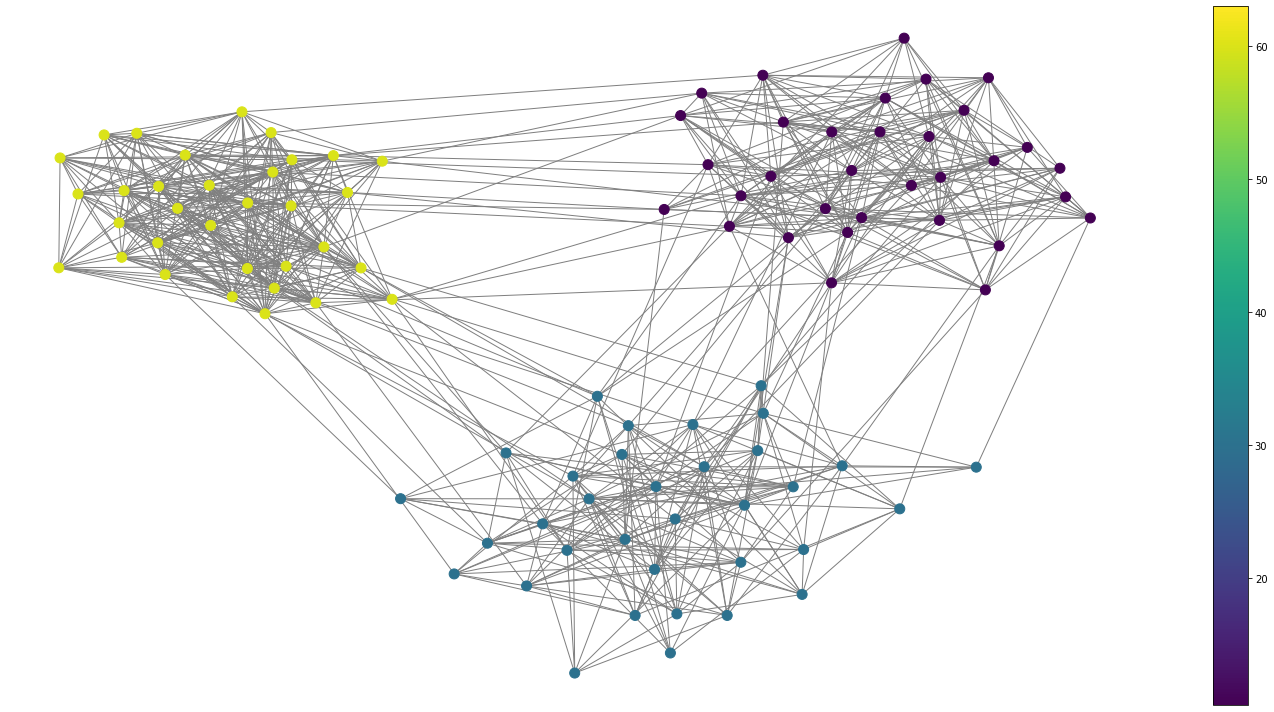

In [13]:
# We create 3 groups of vertices
# Same as those in SBM definition
groups = numpy.array([10] * (graph.N//3) + [60] * (graph.N//3) + [30] * (graph.N-2*graph.N//3))

# Plot
plot_graph(graph, groups)

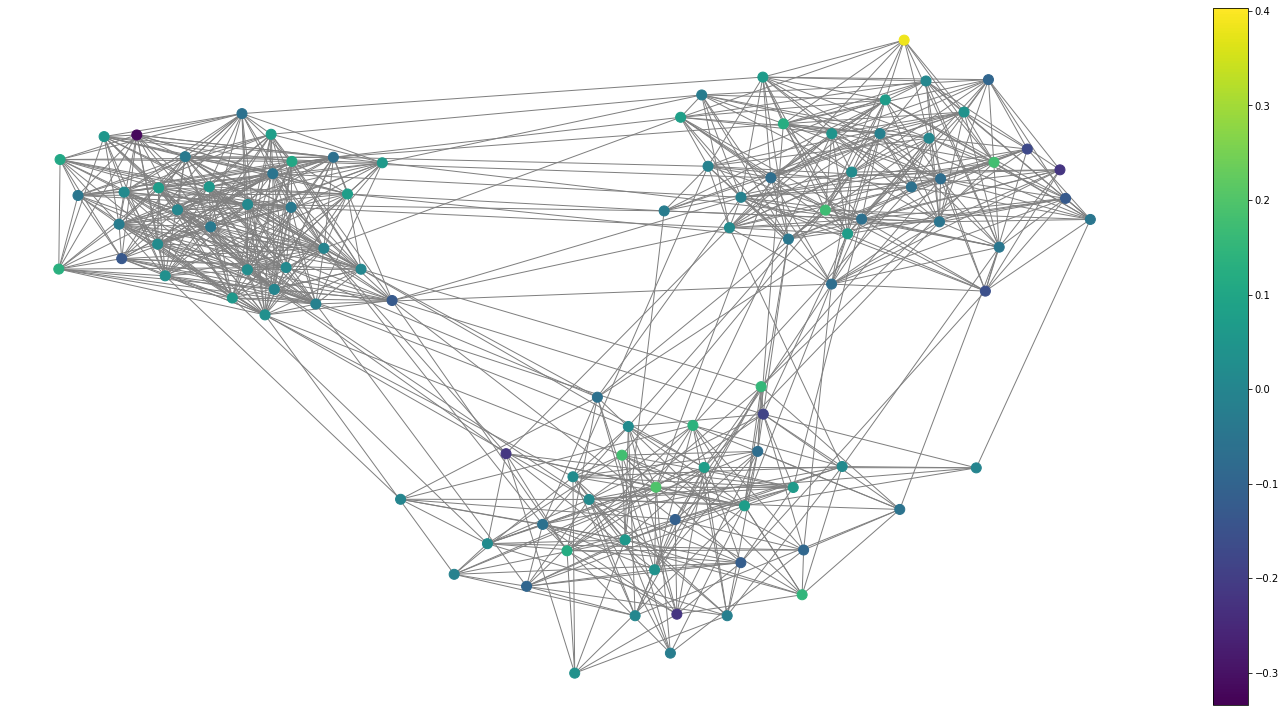

In [14]:
# Signal to analyze is a mix between some frequencies
x = numpy.array([graph.U[i, int(groups[i])] for i in range(graph.N)])
x /= numpy.linalg.norm(x)

# Plot
plot_graph(graph, x)

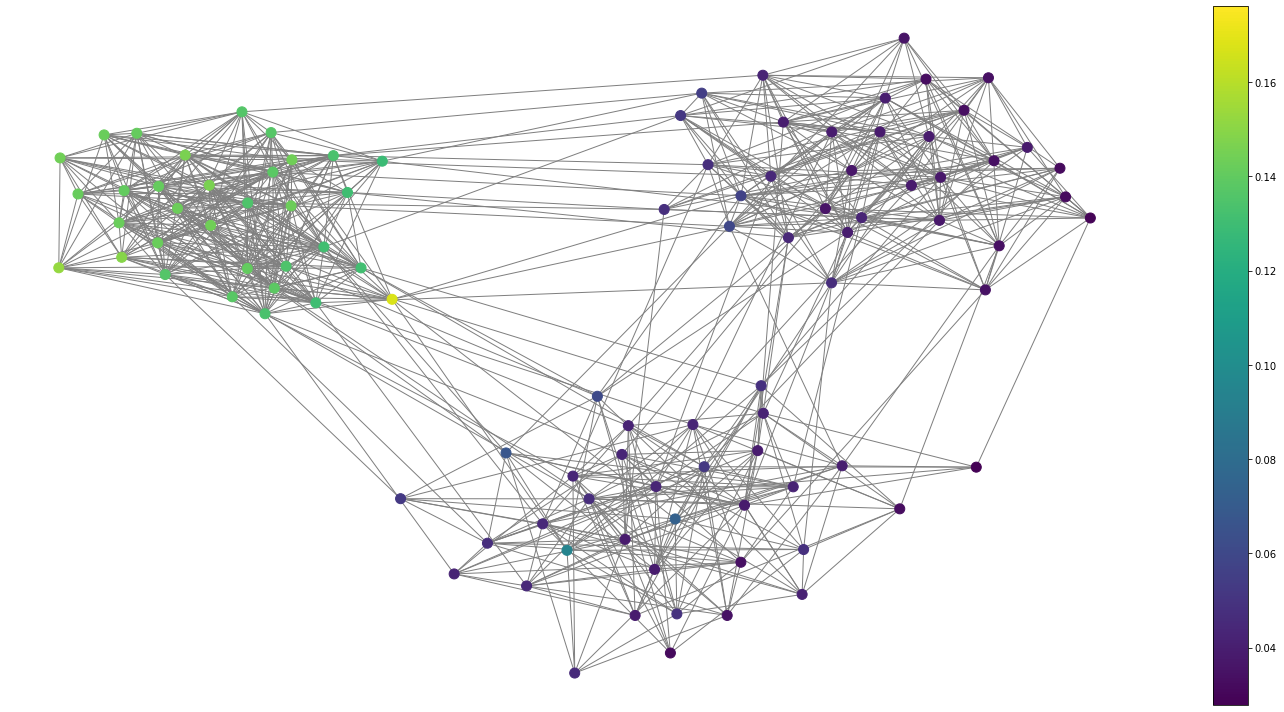

In [15]:
# We use a window defined by a heat kernel
# Needs to be instanciated on a particular vertex to be the object we want
window_kernel = create_heat_kernel(graph, KERNEL_SCALE)
localized_kernel = window_kernel.localize(graph.N//2)

# Plot
plot_graph(graph, localized_kernel)

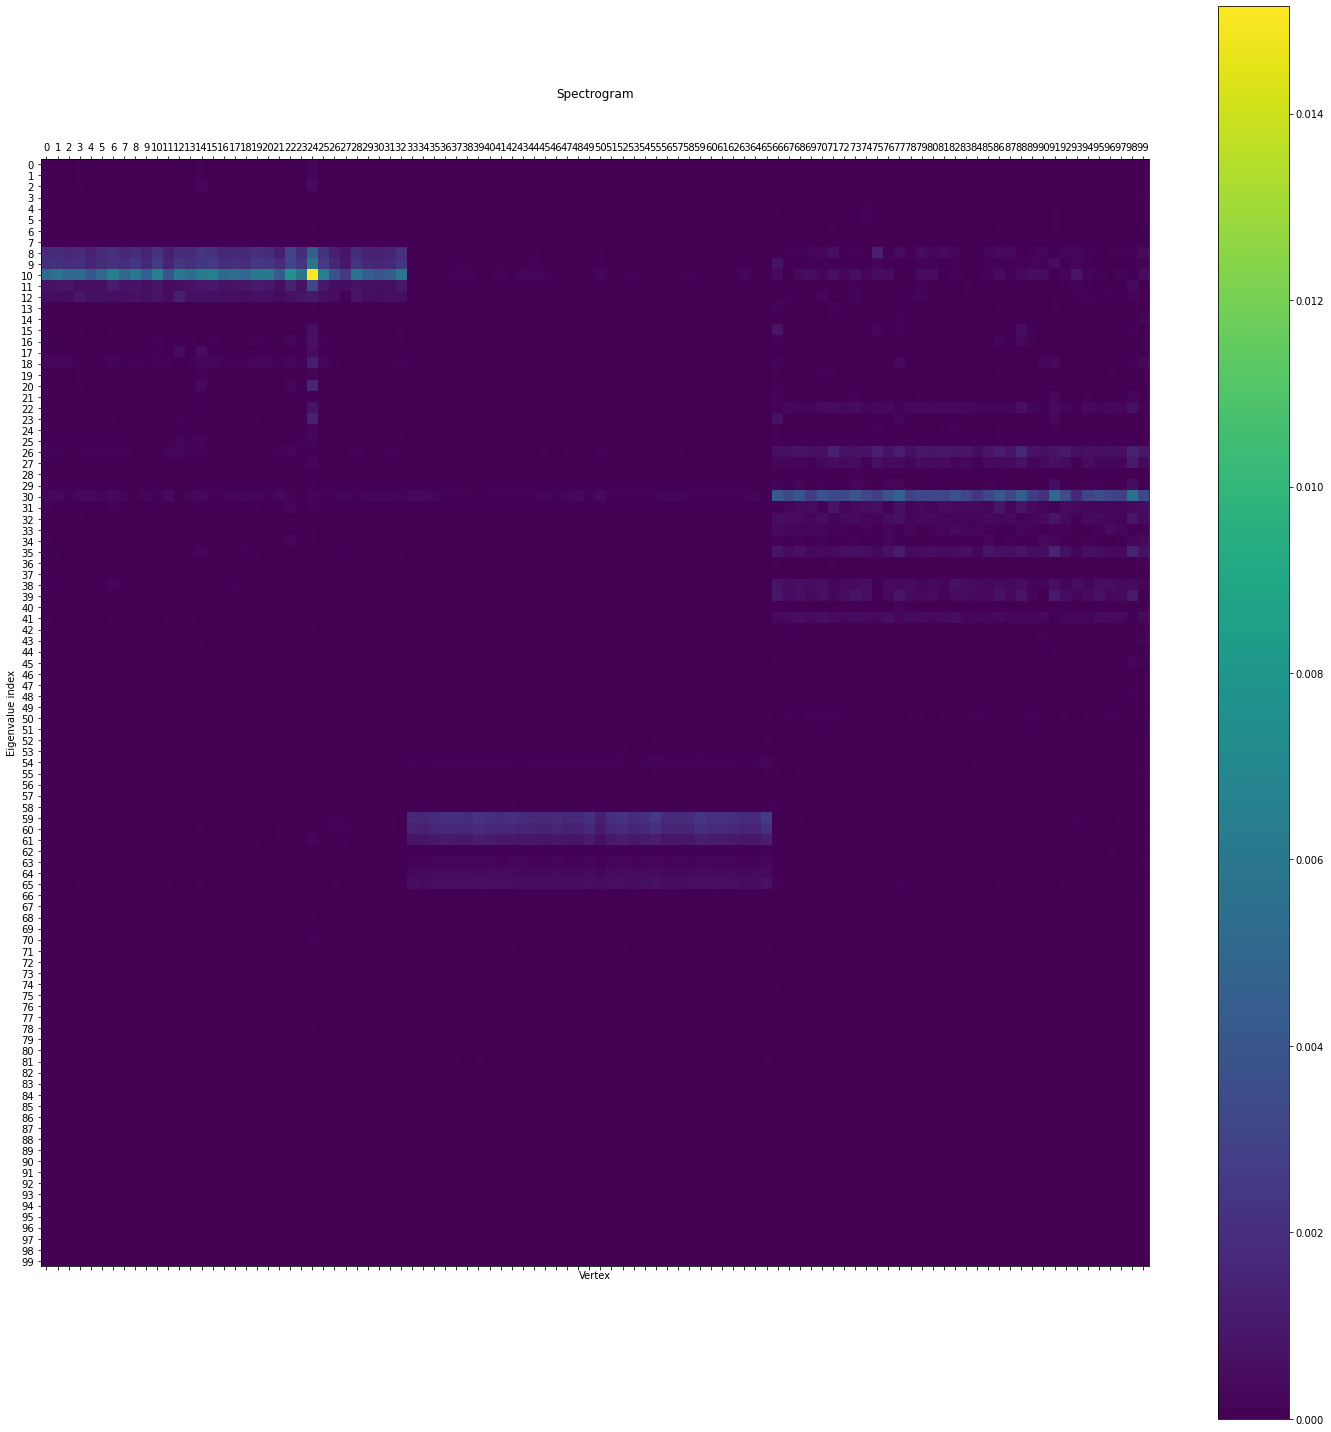

In [16]:
# Graph spectrogram of the signal
spectrogram = compute_graph_spectrogram(graph, x, window_kernel)

# Plot
plot_matrix(spectrogram,
            cols_title="Vertex",
            cols_labels=range(graph.N),
            rows_title="Eigenvalue index",
            rows_labels=range(graph.N),
            title="Spectrogram",
            colorbar=True)

<h1><center>Analysis of spatio-temporal signals</center></h1>

<h2>Create dataset with something varying in space across time</h2>

In [11]:
# Constants
SPACE_GRAPH_ORDER = 100
TIME_GRAPH_ORDER = 100
LOCAL_OBJECT_SIZE = 5
COMEBACK_PENALTY = 3
SPACE_KERNEL_SCALE = 300
TIME_KERNEL_SCALE = 10

In [19]:
# Create some graphs
g_space = create_sensor_graph(SPACE_GRAPH_ORDER)
g_time = create_path_graph(TIME_GRAPH_ORDER)

In [20]:
# Function to generate a local thing around a vertex
# Here we just consider a polynom of the graph
def local_object (graph, center, width=LOCAL_OBJECT_SIZE) :
    dirac = scipy.signal.unit_impulse(graph.N, center)
    signal = numpy.sum([numpy.power(graph.W, i).dot(dirac) for i in range(width)], axis=0)
    signal /= numpy.linalg.norm(signal)
    return signal

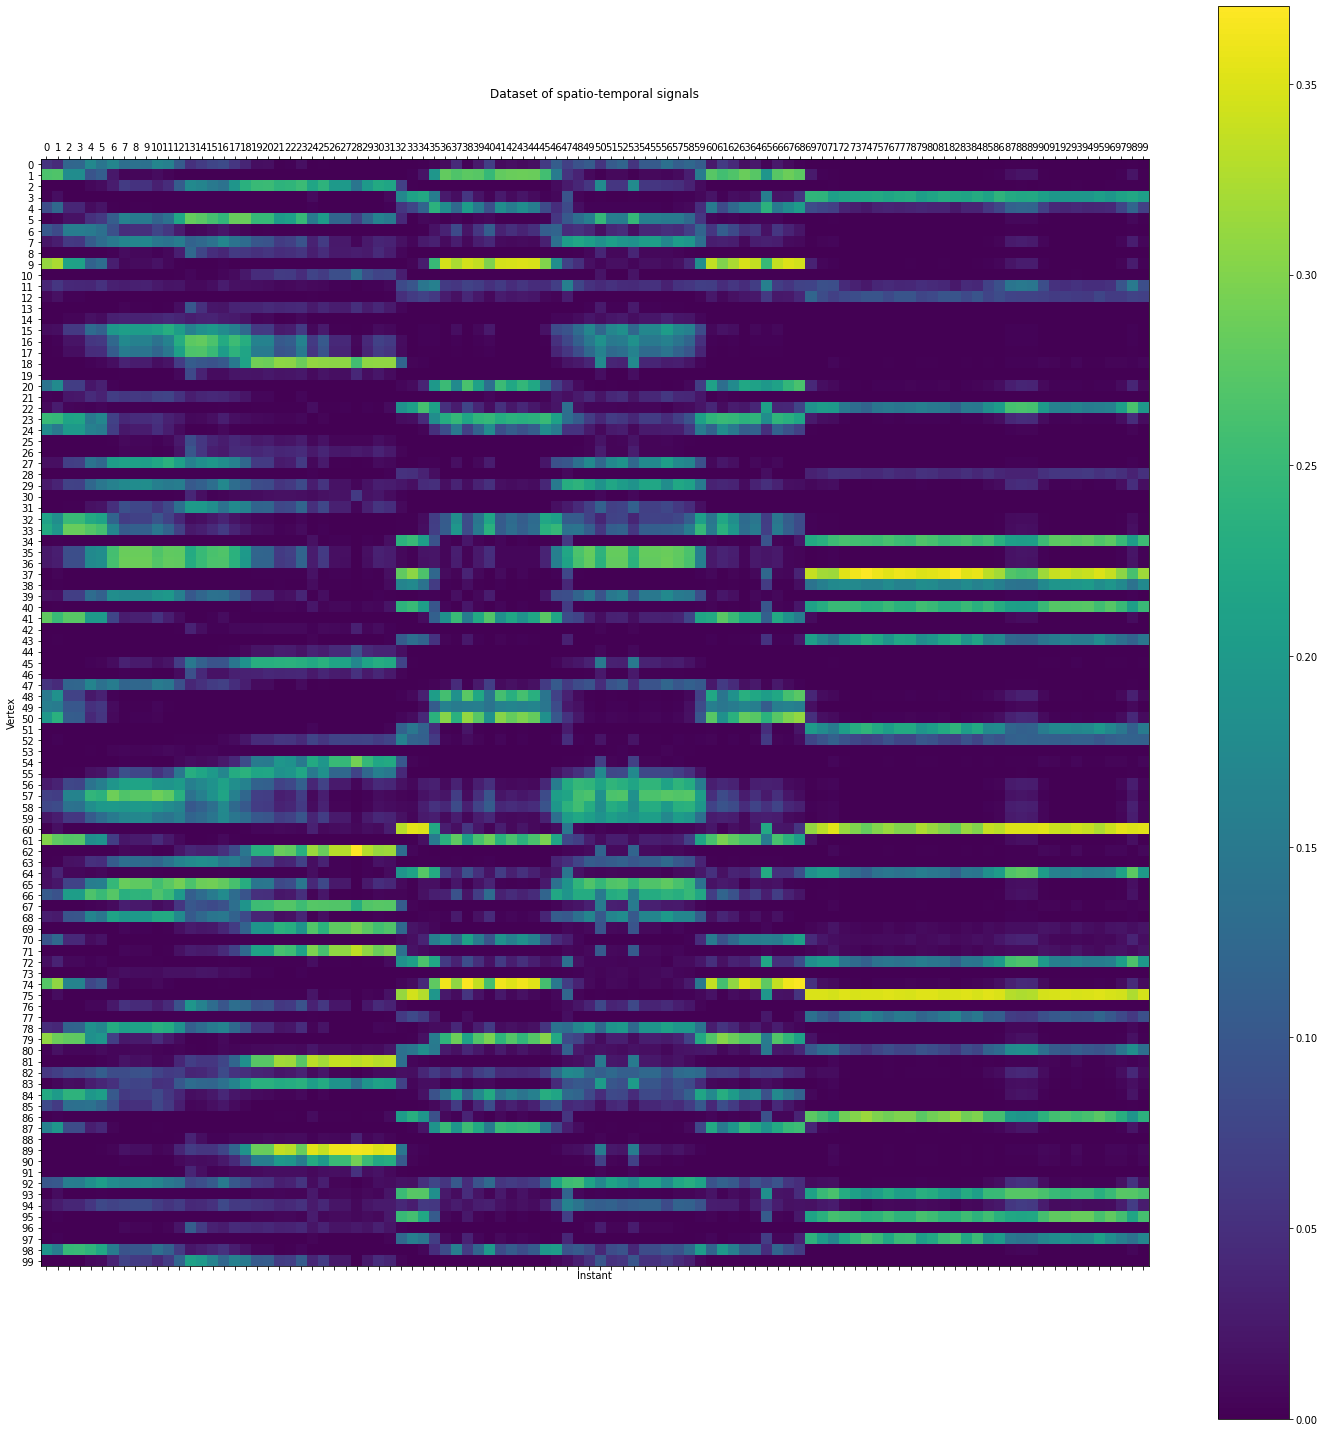

In [21]:
# We move an object around randomly
# We decrease the probability to go to already visited places
signals = numpy.zeros((g_space.N, g_time.N))
next_center = numpy.random.randint(g_space.N)
visited_counts = numpy.array([1 for i in range(g_space.N)])
for t in range(g_time.N) :
    signals[:, t] = local_object(g_space, next_center)
    visited_counts[next_center] += COMEBACK_PENALTY
    neighbors = get_neighbors(g_space, next_center)
    probabilities = 1.0 / visited_counts[neighbors]
    probabilities /= numpy.linalg.norm(probabilities, 1)
    next_center = numpy.random.choice(neighbors, p=probabilities)

# Plot
plot_matrix(signals,
            rows_title="Vertex",
            rows_labels=range(g_space.N),
            cols_title="Instant",
            cols_labels=range(g_time.N),
            title="Dataset of spatio-temporal signals",
            colorbar=True)

<h2>Study it with spectrogram considering dimensions independently</h2>

In [22]:
# Kernel for the spectrogram
window_space_kernel = create_heat_kernel(g_space, SPACE_KERNEL_SCALE)

# Update function for the slider
def update (instant) :
    
    # Compute spectrogram
    spectrogram = compute_graph_spectrogram(g_space, signals[:, instant], window_space_kernel)
    
    # Plot
    plot_matrix(spectrogram,
                cols_title="Vertex",
                cols_labels=range(g_space.N),
                rows_title="Eigenvalue index",
                rows_labels=range(g_space.N),
                title="Graph spectrogram of all values observed at time " + str(instant),
                colorbar=True)

# Slider
ipywidgets.widgets.interact(update, instant=range(g_time.N))

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.update(instant)>

In [23]:
# Kernel for the spectrogram
window_time_kernel = create_heat_kernel(g_time, TIME_KERNEL_SCALE)

# Update function for the slider
def update (vertex) :
    
    # Compute spectrogram
    spectrogram = compute_graph_spectrogram(g_time, signals[vertex, :], window_time_kernel)
    
    # Plot
    plot_matrix(spectrogram,
                cols_title="Instant",
                cols_labels=range(g_time.N),
                rows_title="Eigenvalue index",
                rows_labels=range(g_time.N),
                title="Time spectrogram of all values observed at vertex " + str(vertex),
                colorbar=True)

# Slider
ipywidgets.widgets.interact(update, vertex=range(g_space.N))

interactive(children=(Dropdown(description='vertex', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

<function __main__.update(vertex)>

<h2>Study it with spectrogram considering dimensions jointly</h2>

In [24]:
# Graphs used
graphs = [g_space, g_time]
kernel_scales = [SPACE_KERNEL_SCALE, TIME_KERNEL_SCALE]

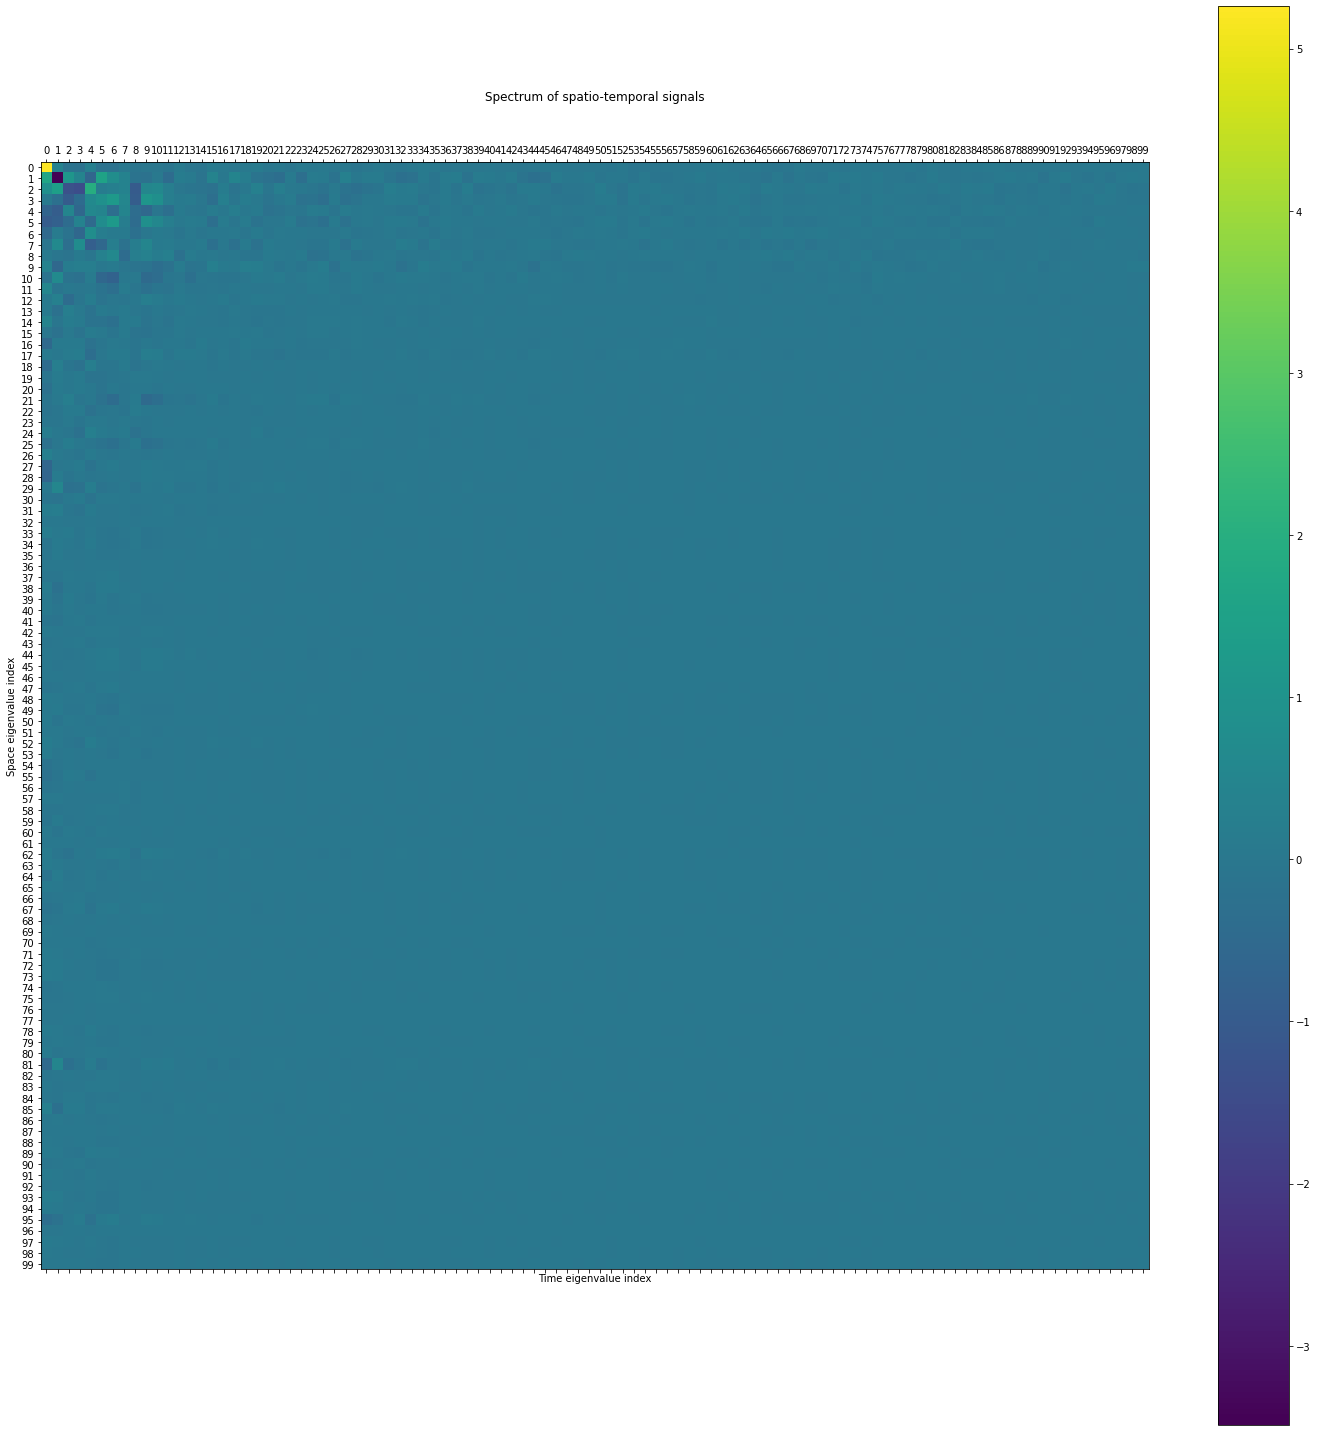

In [25]:
# Compute JFT of all signals
spectrums = compute_jft(graphs, signals)

# Plot
plot_matrix(spectrums,
            rows_title="Space eigenvalue index",
            rows_labels=range(g_space.N),
            cols_title="Time eigenvalue index",
            cols_labels=range(g_time.N),
            title="Spectrum of spatio-temporal signals",
            colorbar=True)

In [26]:
# We localize a heat kernel
window_kernel = create_joint_heat_kernel(graphs, kernel_scales)
localized_kernel = localize_joint_heat_kernel(graphs, window_kernel, [graphs[i].N//2 for i in range(len(graphs))])

# Update function for the slider
def update (instant, vertex) :
    
    # Plot
    plot_graph(graphs[0],
               localized_kernel[:, instant],
               title="Looking at spatial graph for fixed instant " + str(instant))
    plot_graph(graphs[1],
               localized_kernel[vertex, :],
               title="Looking at time graph for fixed vertex " + str(vertex))

# Slider
ipywidgets.widgets.interact(update, instant=range(g_time.N), vertex=range(g_space.N))

interactive(children=(Dropdown(description='instant', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.update(instant, vertex)>